# SOM Visualization


## Description

This notebook contains code for visualizing the contents of hierarchical data (`*.h5`) files produced by [`Sompy_experimentation.ipynb`](Sompy_experimentation.ipynb). The current things it displays are as follows:

 - A set of linear-gradient heatmaps
 - A set of log-gradient heatmaps
 - An interactive interface for browsing through what items are in each cluster
 - A "U-matrix" that highlights regions of high euclidean distance gradients, to identify how well-matching the cluster boundaries are
 
 
 ## Workflow
 
 
 1. Enter the particular codebook file you want to use in [the codebook selection cell](#codebook_selection_cell), change the KM_CLUSTERS value to whatever number of clusters you feel is appropriate, and then rerun the notebook.
 1. Inspect the heatmaps in [the heatmap view cells](#heatmap_view_cell).
 1. Search the cells for materials of interest in [the cluster inspector cell](#cluster_inspector_cell).
 1. Evaluate the accuracy of the fit of the clusters in [the umatrix view cell](#umatrix_view_cell).
 
 
 ## Notes
 
  - The trained SOM has many arrays, one for each parameter it was trained on. This is what is seen in the heatmap views - each heatmap corresponds to one of these arrays.
  - The cluster inspector has various features, which shall be listed here.
      - First, each cluster is given its own tab in the inspector. The order of the tabs by color matches the pattern in the colorbar to the side of the cluster map. You can confirm the color of a given cluster with the colored square next to the cluster's name inside of the tab's frame.
      - When a cluster is selected, you may view its statistical information and contained items in the tables in the tab's frame.
      - You can restrict the number of items shown in the tab by entering a **regular expression**([1](https://en.wikipedia.org/wiki/Regular_expression), [2](https://www.regular-expressions.info/quickstart.html)) that matches the items you wish to see.
      - Once the items have been filtered to your liking, you can hit the "render points" button in order to display all items visible in the table to the cluster map.

In [1]:
import numpy as np
import pandas as pd
import logging
import ipywidgets as widgets
import matplotlib.pyplot as plt
import tables
import sompy
from sompy.sompy import SOMFactory

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [30]:
from tfprop_sompy.jupyter_integration.cluster_inspector import sort_materials_by_cluster, cluster_tabs,\
                                                                make_cluster_graph
from tfprop_sompy.tfprop_vis import render_posmap_to_axes, kmeans_clust, render_points_to_axes,\
                                    show_posmap, ViewTFP, dataframe_to_coords , clusteringmap_category,\
                                    UMatrixTFP

In [4]:
# This makes all the loggers stay quiet unless it's important
logging.getLogger().setLevel(logging.WARNING)

In [5]:
# Paste name of file generated by training in Sompy_experimentation
CODEBOOK_FILE = 'som_codemat_4props_20-02-14.h5'

# Number of clusters for k-means clustering
KM_CLUSTERS = 5

In [6]:
# Creates necessary pd dataframes for visualization
stored_cb_matrix = pd.read_hdf(CODEBOOK_FILE, 'sm_codebook_matrix')
stored_mapsize = pd.read_hdf(CODEBOOK_FILE, 'sm_codebook_mapsize').values
mats_df = pd.read_hdf(CODEBOOK_FILE, 'sm_data')

# FIXME:
# We do a hack using the "pytables" library in order to extract the information
# For some reason pandas doesn't like to read object series out of h5 files
stored_columns = None
stored_matfamilies = None
with tables.open_file(CODEBOOK_FILE, "r") as store:
    # We normally get byte strings from this
    # The mapping operation turns them all into unicode strings ready for presentation
    
    # Obtaining the column names
    stored_columns = list(map(lambda x: x.decode('utf-8'), store.root.sm_codebook_columns.property_names.read()))
    
    # Obtaining the material identification
    stored_matfamilies = list(map(lambda x: x, store.root.sm_codebook_matfamilies.material_families.read()))

In [7]:
# Insert new column with material identification
mats_df["Row"] = stored_matfamilies

In [8]:
# Function located in sompy.py
# Creates a SOM object
sm = SOMFactory.build(mats_df[stored_columns].values, 
                mapsize=(*stored_mapsize,),
                normalization="var", 
                initialization="pca", 
                component_names=stored_columns)

In [41]:
# Calculate quantization error value
sm.calculate_quantization_error()

0.06328107987693825

In [42]:
# Calculate topographic error value
sm.calculate_topographic_error()

0.15178571428571427

In [9]:
# SOM object contains a codebook object
# Setting the matrix to the values of our current data. 
sm.codebook.matrix = stored_cb_matrix.values

In [11]:
# Using scikit-learn K-means clustering method to predict cluster fit index for our SOM object.
cl_labels = kmeans_clust(sm, KM_CLUSTERS)

Performing K-means clustering to SOM trained data...


In [12]:
# Setting parameters for our heatmap
heatmap_size = (20, 20)
heatmap_col_sz = 4
gauss_alpha = None

cmap = plt.get_cmap('RdYlBu_r')  # set color map using Matplolib function

#Initializing a map viewer imported from mapview.py
viewTFP = ViewTFP(*heatmap_size, '', stdev_colorscale_coeff=1., text_size=14)

In [13]:
# Initializing widget
my_out = widgets.Output()

# No scaling
viewTFP.knee_value = 0.0

# Displaying heatmap through the widget
# Uses matplotlib functions
with my_out:
    print("Linear scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, isOutHtmap=False)
my_out

Output()

In [14]:
my_out = widgets.Output() # Initializing widget
cmap = plt.get_cmap('RdYlBu_r')  # set color map

# No scaling
viewTFP.knee_value = 0.0
with my_out:
    print("Log scaling")
    viewTFP.show(sm, cl_labels, col_sz=heatmap_col_sz,
                         which_dim='all', desnormalize=True, col_norm='mean',
                         cmap=cmap, normalizer="log")
my_out

Output()

In [26]:
mats_df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            550, 551, 552, 553, 554, 555, 556, 557, 558, 559], dtype='int64', length=560)

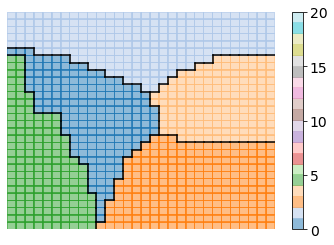

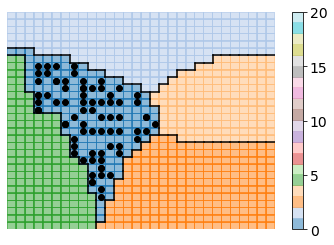

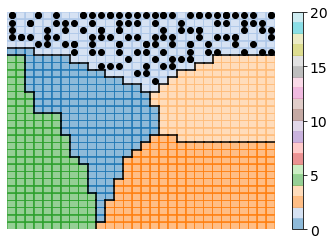

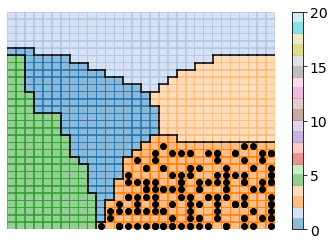

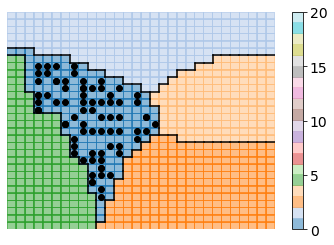

In [24]:
# Creating 2-D list organized by clusters
# 5 cluster = 5 lists within this list
clusters_list = sort_materials_by_cluster(sm, mats_df, cl_labels)

# This makes it so it will display the full lists
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# This should be the last statement of the cell, to make it display
# That, or assign the return value to a variable, and have that variable be the final expression in a cell
cluster_tabs(sm, mats_df, clusters_list, cl_labels)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 0, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2,

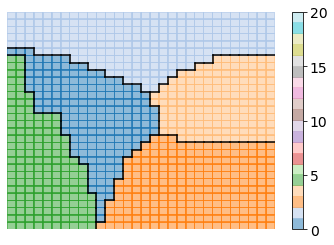

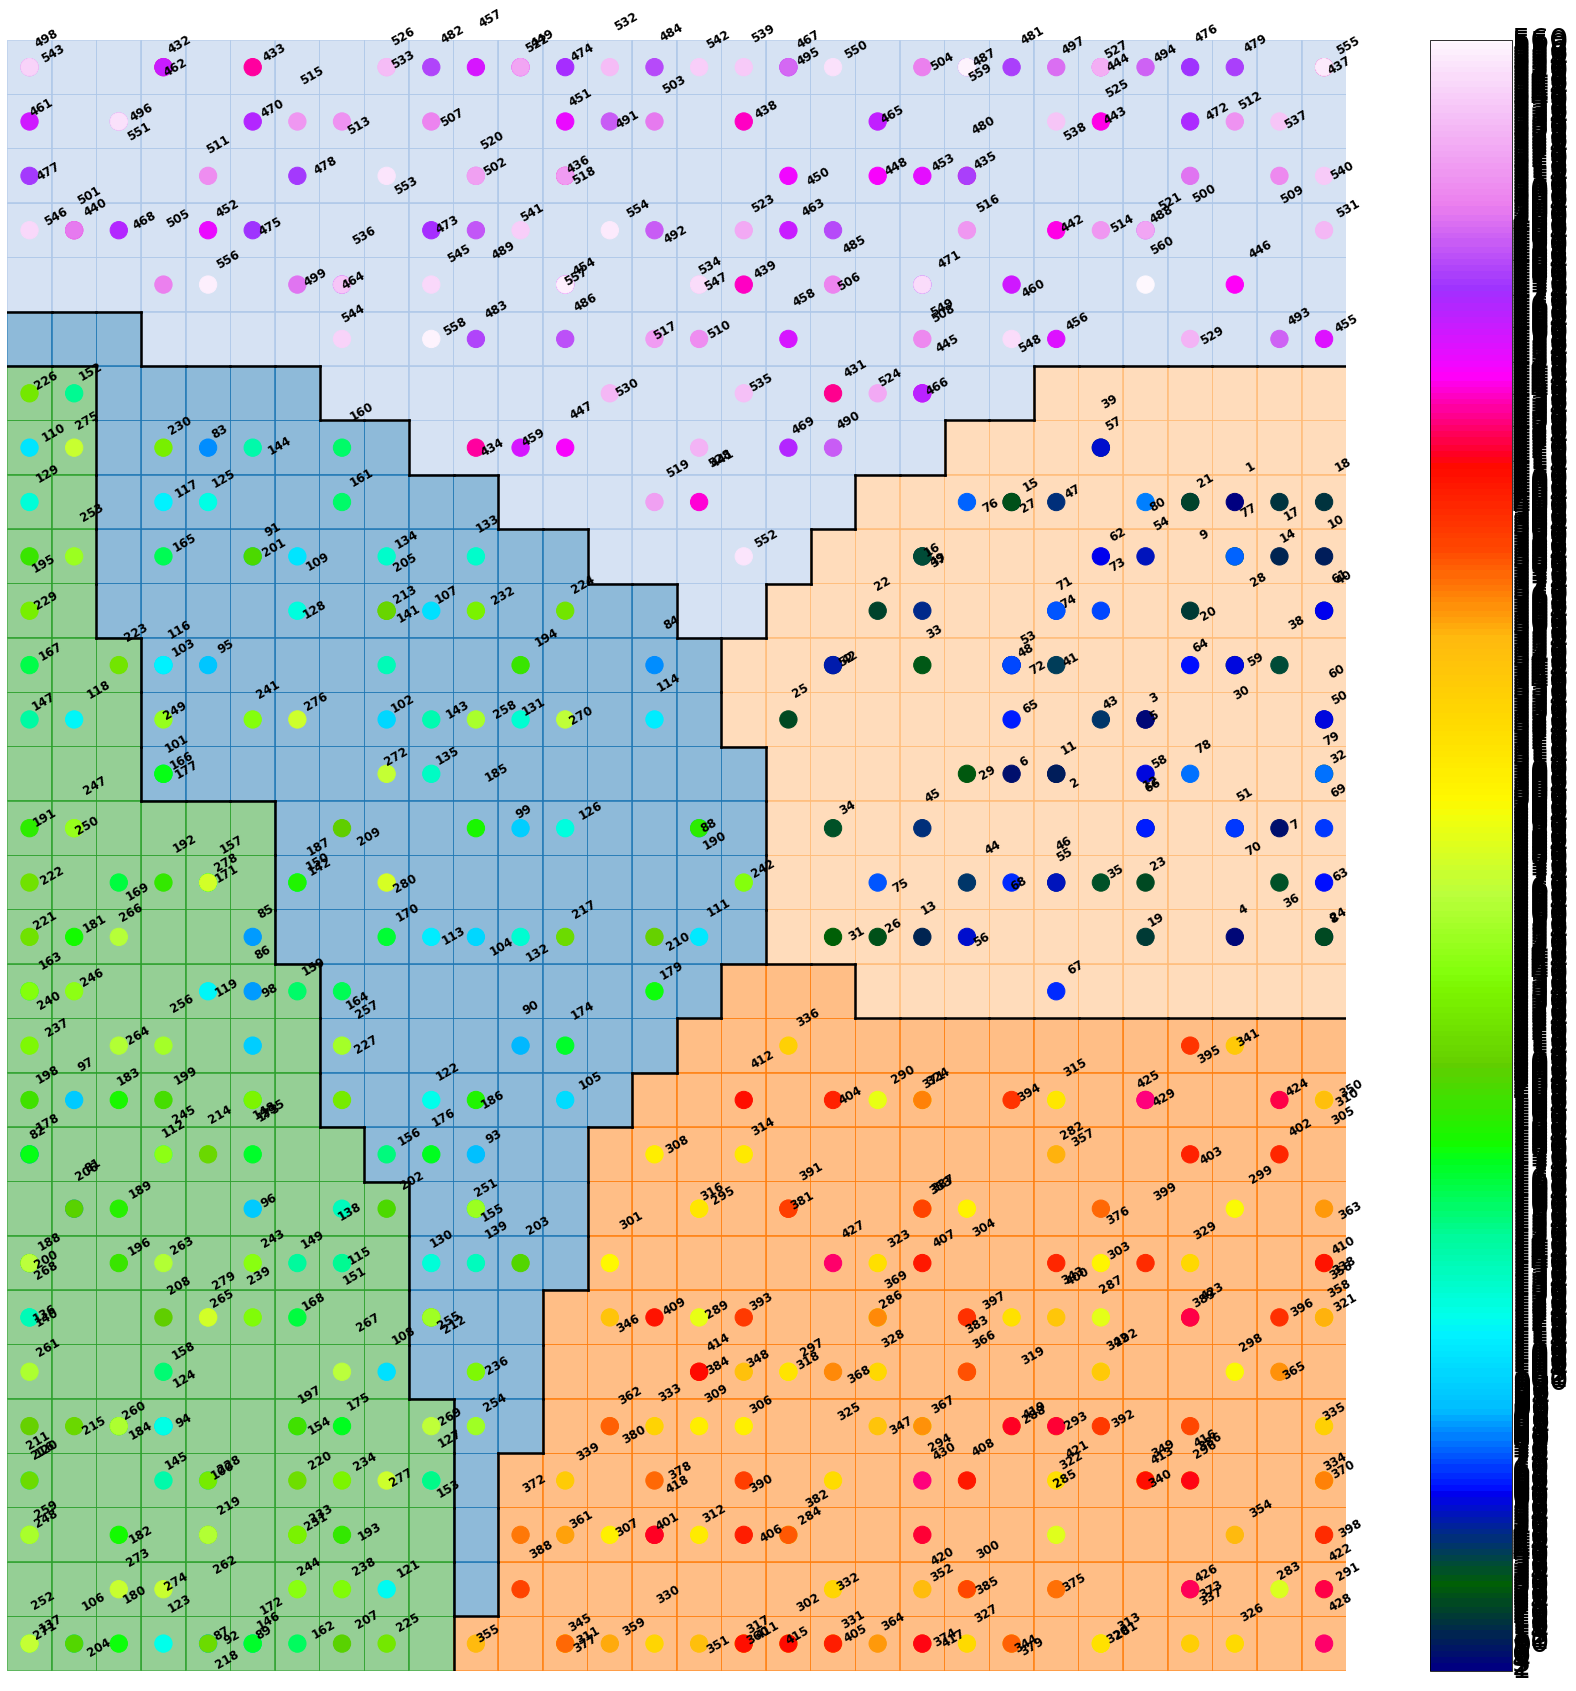

In [35]:
# Generating another cluster map to overlay material identification
fig, ax = make_cluster_graph(sm, cl_labels)

# Labels material identification on each data points on the cluster map
# Requires a column for color category
clusteringmap_category(ax, sm, KM_CLUSTERS, my_dataframe, "Row", my_dataframe["Row"], 'plot.png')

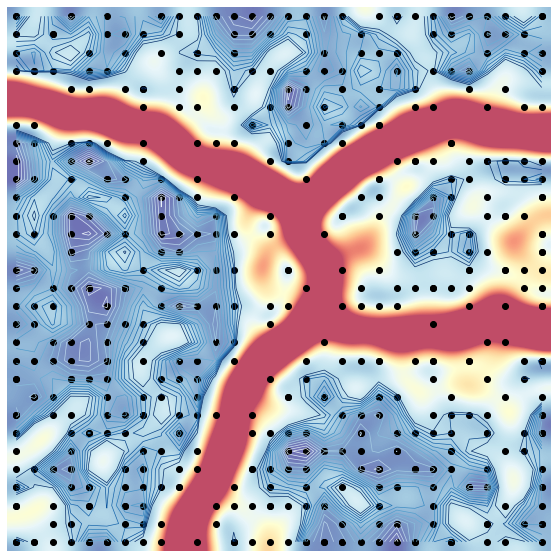

Saving figure of U-matrix to umatrix.png...


([], array([[0.10716044, 0.153947  , 0.14327449, 0.10299294, 0.13265501,
         0.14710192, 0.10046805, 0.08088191, 0.08703503, 0.08762524,
         0.09196454, 0.09702834, 0.08560691, 0.09390819, 0.09131332,
         0.07299989, 0.09568384, 0.10633002, 0.10616125, 0.09638673,
         0.06467909, 0.06435995, 0.07408766, 0.13636928, 0.39072579,
         0.35101909, 0.11841244, 0.10685841, 0.12032325, 0.09743699],
        [0.1257419 , 0.14678059, 0.15932454, 0.12018811, 0.11296578,
         0.15201945, 0.14125627, 0.09841626, 0.08195166, 0.08956349,
         0.09364   , 0.09713941, 0.09489566, 0.10458336, 0.09525953,
         0.07981796, 0.10296636, 0.11474432, 0.12067262, 0.11444994,
         0.08819114, 0.09083068, 0.09383241, 0.1646745 , 0.39978341,
         0.28490399, 0.10359367, 0.10254316, 0.12194108, 0.12669173],
        [0.13656286, 0.13077207, 0.14620851, 0.11884619, 0.08584955,
         0.11916485, 0.15073102, 0.12037774, 0.09549789, 0.09530724,
         0.08588568, 0.08941

In [37]:
# Initializing size
umat_size = (50, 50)

# Utilizes SOMPY's UMatrixView, which uses matplotlib
umat = UMatrixTFP(*umat_size, 'U-matrix')

# Plots the UMatrix map
# Must set "ifOutUmat" to True in order to output a image file
umat.show(sm, my_dataframe, my_dataframe, 'umatrix.png',cmap=cmap, isOutUmat=True)